# Exploratory Data Analysis of RIID data ..

## Imports

In [5]:
import plotly.express as px
from plotly.subplots import make_subplots
from matplotlib import pyplot
import plotly.graph_objects as go
import gc

import sys, os
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import re
import dask
import distributed
from dask import dataframe as dd 

%matplotlib inline

In [3]:
!ls

00_riid_eda.ipynb		 mydask.png
01-simplequestionaverages.ipynb  nohup.out
02-NotsoNaiveBayes.ipynb	 __pycache__
dask-worker-space		 qdf.pkl
example_sample_submission.csv	 questions.csv
example_test.csv		 riiideducation
full_df.pkl			 riiid-test-answer-prediction.zip
lc_utils_2020.py		 tdf.pkl
lectures.csv			 test_exploration.ipynb
LendingClub-AiImmersion.ipynb	 train.csv
mm_147900.nbm


## Data Description from Kaggle

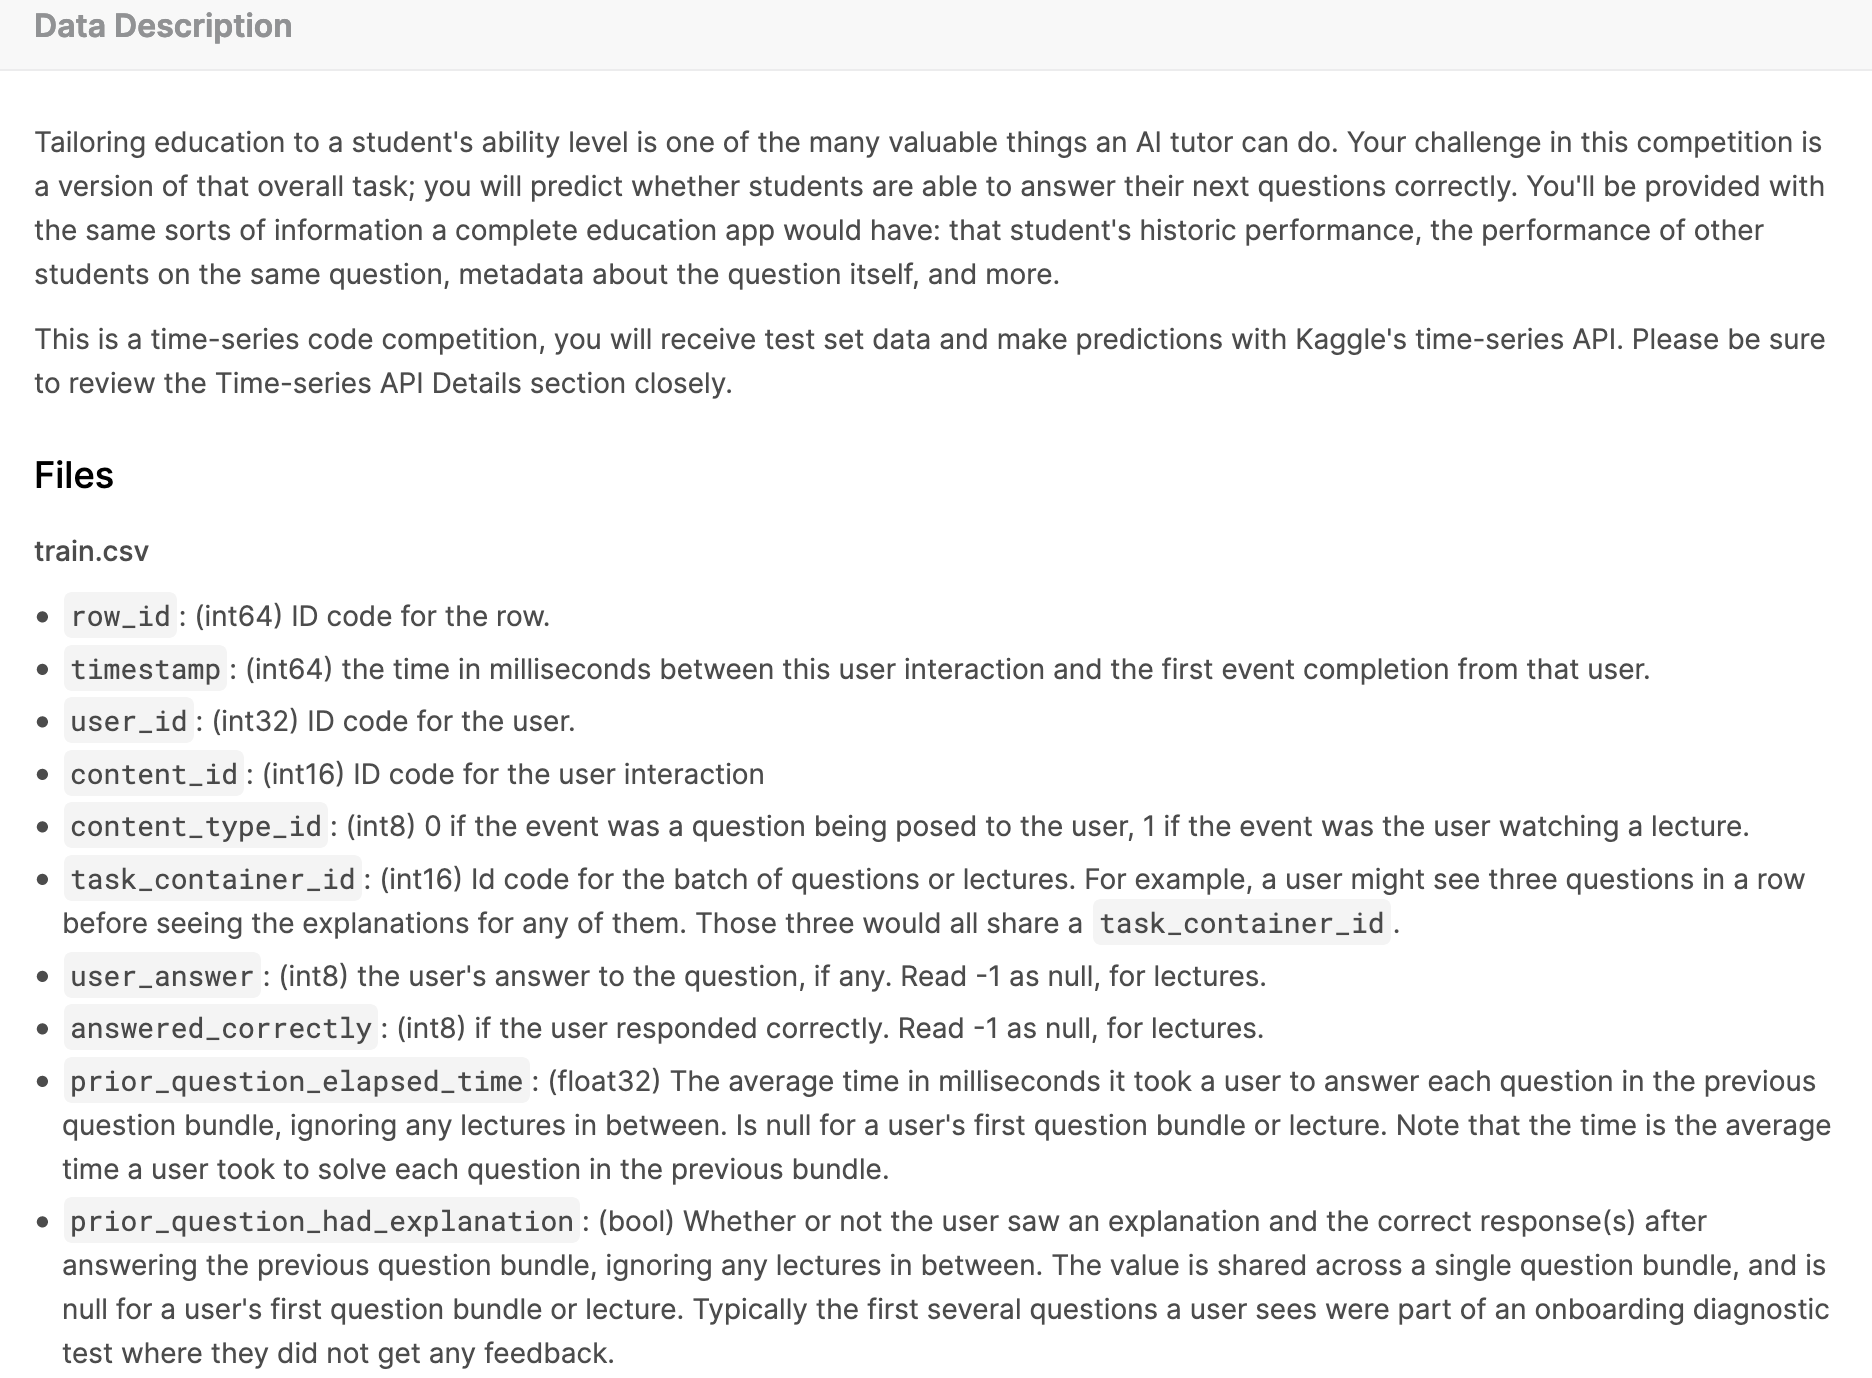

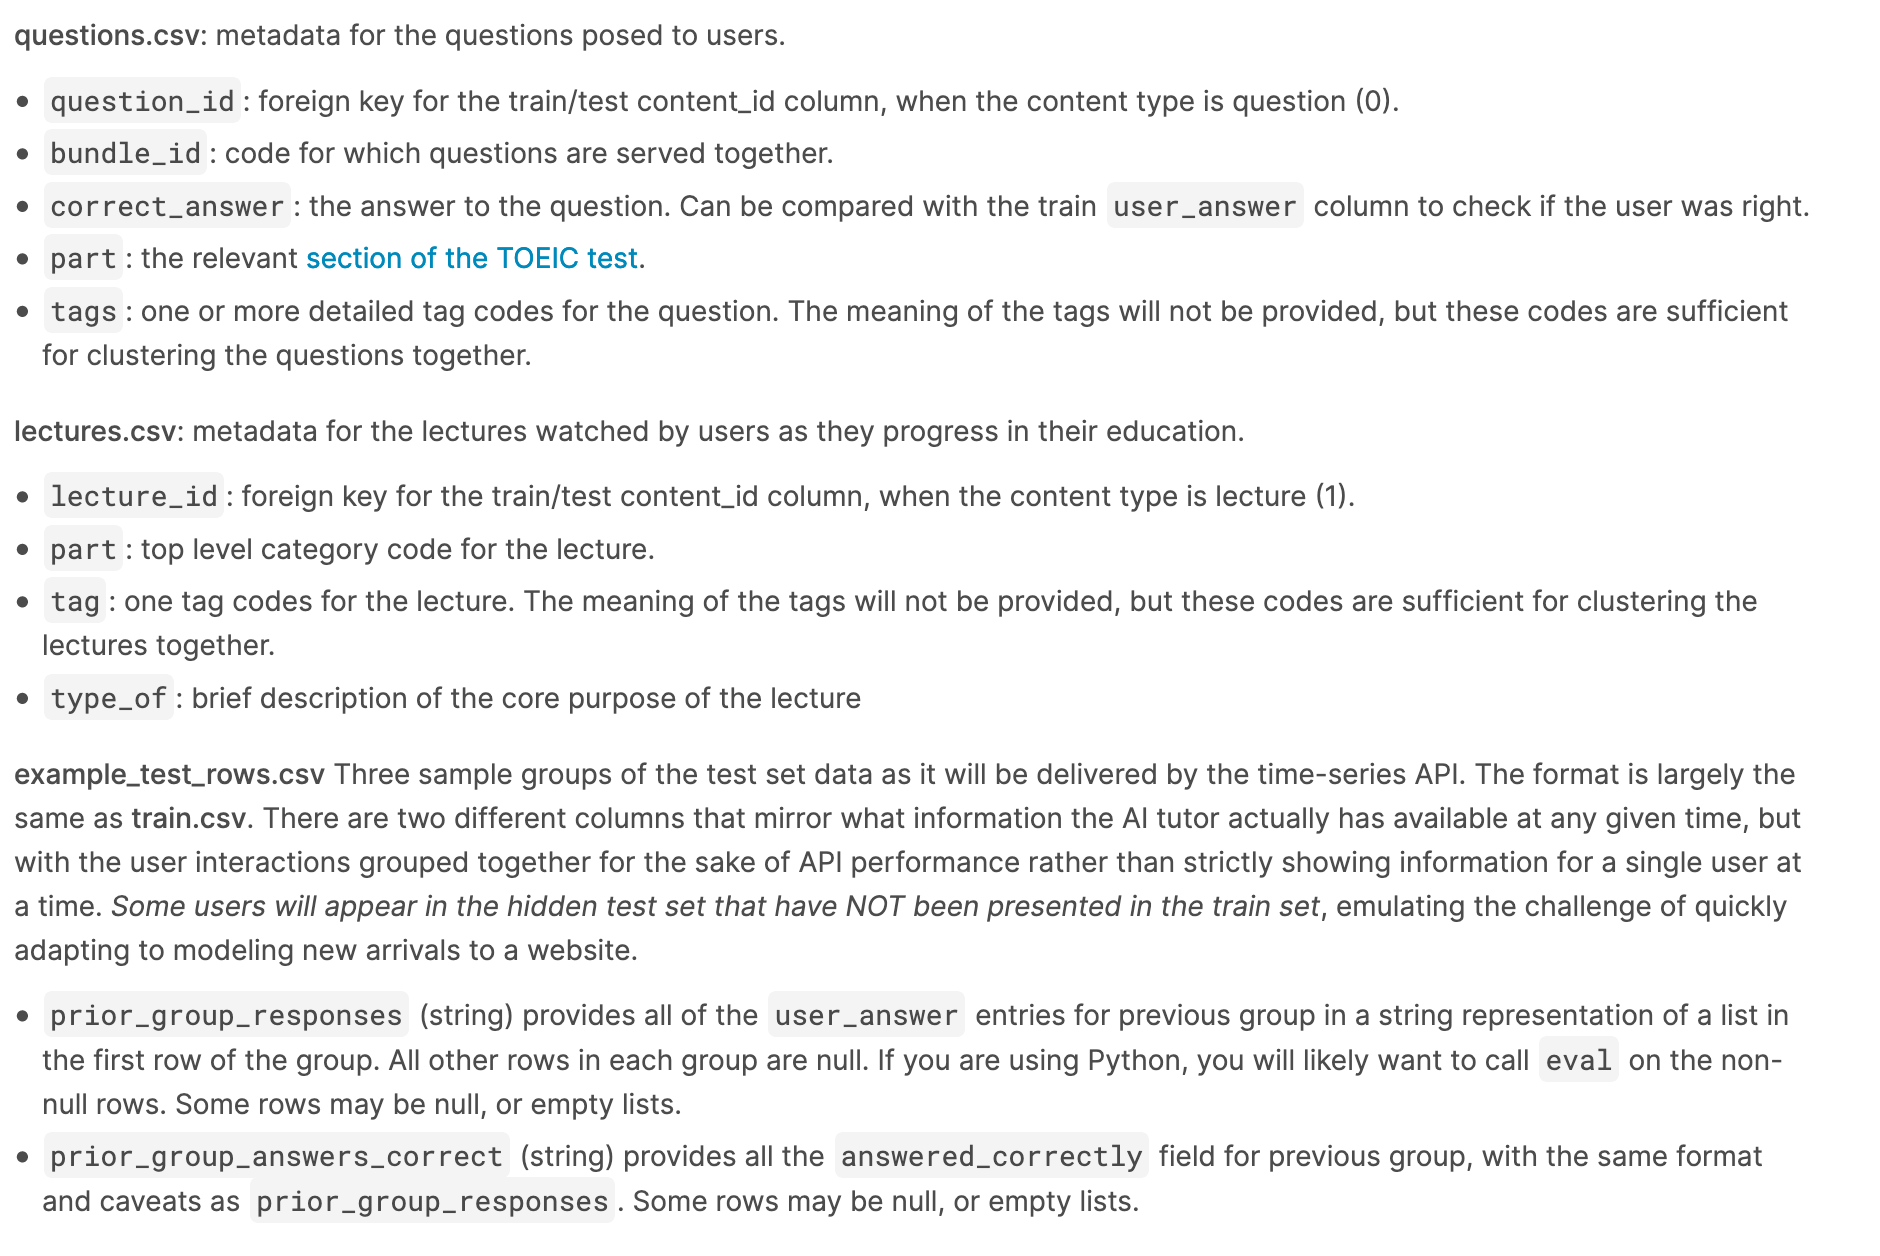

In [4]:
# Project Configuration !

# Todo Add get config



## Load Data

In [6]:
!ls *csv

example_sample_submission.csv  lectures.csv   train.csv
example_test.csv	       questions.csv


In [7]:
def load_data() :
    train_df = None
    questions_df = None
    if(os.path.isfile("tdf.pkl")) :
    # !pip install fastparquet
        train_df = pd.read_pickle("tdf.pkl")
        questions_df = pd.read_pickle("qdf.pkl")
    else :
    
    
        train_df = pd.read_csv('./train.csv',
                           usecols=[1, 2, 3, 4, 5, 7, 8, 9],
                           dtype={'timestamp': 'int64',
                                  'user_id': 'int32',
                                  'content_id': 'int16',
                                  'content_type_id': 'int8',
                                  'task_container_id': 'int16',
                                  'answered_correctly':'int8',
                                  'prior_question_elapsed_time': 'float32',
                                  'prior_question_had_explanation': 'boolean'}
                           )
        questions_df = pd.read_csv("questions.csv",
                            dtype={'question_id': 'int64',
                                  'bundle_id': 'int32',
                                  'correct_answer': 'int16',
                                  'part': 'int8',
                                  'tags': 'object'})
    print(train_df.info())
    print(questions_df.info())
    return train_df, questions_df

train_df, questions_df = load_data()
display(train_df)
display(questions_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99271300 entries, 0 to 99271299
Data columns (total 13 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   timestamp                       int64  
 1   user_id                         int32  
 2   content_id                      int16  
 3   content_type_id                 int8   
 4   task_container_id               int16  
 5   answered_correctly              int8   
 6   prior_question_elapsed_time     float32
 7   prior_question_had_explanation  boolean
 8   question_id                     int64  
 9   bundle_id                       int32  
 10  correct_answer                  int16  
 11  part                            int8   
 12  tags                            object 
dtypes: boolean(1), float32(1), int16(3), int32(2), int64(2), int8(3), object(1)
memory usage: 5.1+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 colu

timestamp     user_id  content_id  content_type_id  \
0                 0         115        5692                0   
1             56943         115        5716                0   
2            118363         115         128                0   
3            131167         115        7860                0   
4            137965         115        7922                0   
...             ...         ...         ...              ...   
99271295  428564420  2147482888        3586                0   
99271296  428585000  2147482888        6341                0   
99271297  428613475  2147482888        4212                0   
99271298  428649406  2147482888        6343                0   
99271299  428692118  2147482888        7995                0   

          task_container_id  answered_correctly  prior_question_elapsed_time  \
0                         1                   1                          NaN   
1                         2                   1                      37000.0   
2                         0                   1                      55000.0   
3                         3                   1                      19000.0   
4                         4                   1                      11000.0   
...                     ...                 ...                          ...   
99271295                 22                   1                      18000.0   
99271296                 23                   1                      14000.0   
99271297                 24                   1                      14000.0   
99271298                 25                   0                      22000.0   
99271299                 26                   1                      29000.0   

          prior_question_had_explanation  question_id  bundle_id  \
0                                   <NA>         5692       5692   
1                                  False         5716       5716   
2                                  False          128        128   
3                                  False         7860       7860   
4                                  False         7922       7922   
...                                  ...          ...        ...   
99271295                            True         3586       3586   
99271296                            True         6341       6341   
99271297                            True         4212       4212   
99271298                            True         6343       6343   
99271299                            True         7995       7995   

          correct_answer  part        tags  
0                      3     5         151  
1                      2     5         168  
2                      0     1  131 149 92  
3                      0     1  131 104 81  
4                      1     1  131 149 92  
...                  ...   ...         ...  
99271295               0     5           8  
99271296               3     5          60  
99271297               3     5          95  
99271298               0     5          60  
99271299               3     5          80  

[99271300 rows x 13 columns]

question_id  bundle_id  correct_answer  part            tags
0                0          0               0     1   51 131 162 38
1                1          1               1     1       131 36 81
2                2          2               0     1  131 101 162 92
3                3          3               0     1  131 149 162 29
4                4          4               3     1    131 5 162 38
...            ...        ...             ...   ...             ...
13518        13518      13518               3     5              14
13519        13519      13519               3     5               8
13520        13520      13520               2     5              73
13521        13521      13521               0     5             125
13522        13522      13522               3     5              55

[13523 rows x 5 columns]

### Convert to Dask

In [7]:
## Cache data 
# train_df.to_pickle("tdf.pkl")
# questions_df.to_pickle("qdf.pkl")

In [8]:
train_ddf = dd.from_pandas(train_df,npartitions=50) # approx 20 seconds

In [9]:
p=print
p(train_ddf.npartitions)
#p(train_ddf.divisions)


50


### Notebook Funcs

In [10]:
# utility print function
def nprint(mystring) :
    print("**{}** : {}".format(sys._getframe(1).f_code.co_name,mystring))


In [20]:
def quick_overview_1d_v2(df) :
    '''
    Prints useful statistics about the dataframe ...
    '''
    df_meta = pd.DataFrame(df.dtypes, columns=["dtype"])
    nprint("There are " + str(len(df)) + " observations in the dataset.")
    nprint("There are " + str(len(df.columns)) + " variables in the dataset.")

    nprint("\n\n")
    nprint("\n****************** Histogram of data types  *****************************\n")
    nprint("use df.dtypes ...")
    print(df_meta['dtype'].value_counts())

    # Cardinality Report
    nprint("\n\n")
    nprint("\n****************** Generating Cardinality Report (all types) *****************************\n")
    #tmpdf = df.select_dtypes(include=['object'])
    # Cardinality report
    card_count = []
    card_idx = []
    for c in df.columns :
        #print("{} {} ".format(c, len(df[c].value_counts())))
        card_count.append(len(df[c].value_counts()))
        card_idx.append(c)
    card_df = pd.DataFrame(card_count, index =card_idx, 
                                          columns =['cardinality']) 
    df_meta = df_meta.join(card_df, how="outer")
    
    nprint("\n****************** Generating NaNs Report *****************************\n")
    nan_df = pd.DataFrame(df.isna().sum(), columns=['nan_count'])
    df_meta = df_meta.join(nan_df, how="outer")
    # Add pct missing
    df_meta['pct_missing'] = 100 * (df_meta['nan_count'] / len(df))

    nprint("\n******************Generating Descriptive Statistics (numerical columns only) *****************************\n")
    #print(" running df.describe() ....")
    desc_df = df.describe().transpose()
    df_meta = df_meta.join(desc_df, how="outer")
    
    df_meta['dtype'] = df_meta['dtype'].astype(str)
    df_meta = df_meta.sort_values(by=['dtype'],ascending=False)
    df_meta = df_meta.transpose()
    display(df_meta)

    cat_cols = df.select_dtypes(include=['object','boolean']).columns
    num_cols = df.select_dtypes(include=['float64','int8','int16','int32','int64']).columns

    return (df_meta[cat_cols].iloc[0:4,:], df_meta[num_cols])


# Answered Correctly Summaries - Dask Aggregates

In [11]:
train_ddf.groupby('answered_correctly').agg({'answered_correctly': ['count']}).head()

/gpfs/home/s4s004/vanstee/anaconda3/envs/oce-pytorch-1.6/lib/python3.6/site-packages/dask/dataframe/core.py:6194: UserWarning:

Insufficient elements for `head`. 5 elements requested, only 2 elements available. Try passing larger `npartitions` to `head`.



answered_correctly
                                count
answered_correctly                   
0                            34026673
1                            65244627

In [12]:
train_ddf.groupby('content_id').agg({'answered_correctly': ['sum','count']}).head(20)

answered_correctly       
                          sum  count
content_id                          
0                      6266.0   6903
1                      6589.0   7398
2                     24890.0  44905
3                     17906.0  22973
4                     19461.0  31736
5                      8383.0   9727
6                     26910.0  56707
7                     14363.0  16585
8                      7738.0   8535
9                     14389.0  47346
10                    21219.0  31024
11                     5937.0   6694
12                    15421.0  20294
13                     7977.0   8991
14                    12095.0  15125
15                    14321.0  20295
16                     2315.0   5439
17                     7396.0   8503
18                    17362.0  20966
19                     9203.0  11127

# Question and User Level Summary - Dask

## Join Data

Train_df holds the majority of the data.  There is a questions data set that we can merge.  It has information about what the correct answer was.

* First join non lecture content id together.  Currently discard lecture data

In [19]:
%%time
# Dask Join [non smart ...]
# %time
# Remove lecture data , lecture data is content_type_id = 1
train_ddf = train_ddf[train_ddf["content_type_id"]==0]

# Join data !
train_q_ddf = train_ddf.merge(questions_df,how="left",left_on="content_id",right_on="question_id")
train_q_ddf = train_q_ddf.persist()

# 5 partions ~ 33 seconds
# 50 partitions ~ 22.1 seconds
# 100 partions ~ 23 seconds
# 500 partions ~ 28 seconds

CPU times: user 49.1 s, sys: 1.88 s, total: 51 s
Wall time: 26.3 s


In [21]:
train_q_ddf

Dask DataFrame Structure:
               timestamp user_id content_id content_type_id task_container_id answered_correctly prior_question_elapsed_time prior_question_had_explanation question_id_x bundle_id_x correct_answer_x part_x  tags_x question_id_y bundle_id_y correct_answer_y part_y  tags_y
npartitions=50                                                                                                                                                                                                                                                                 
                   int64   int32      int16            int8             int16               int8                     float32                        boolean         int64       int32            int16   int8  object         int64       int32            int16   int8  object
                     ...     ...        ...             ...               ...                ...                         ...                            ...           ...         ...              ...    ...     ...           ...         ...              ...    ...     ...
...                  ...     ...        ...             ...               ...                ...                         ...                            ...           ...         ...              ...    ...     ...           ...         ...              ...    ...     ...
                     ...     ...        ...             ...               ...                ...                         ...                            ...           ...         ...              ...    ...     ...           ...         ...              ...    ...     ...
                     ...     ...        ...             ...               ...                ...                         ...                            ...           ...         ...              ...    ...     ...           ...         ...              ...    ...     ...
Dask Name: merge, 50 tasks

In [14]:
%%time 
# Smart Dask Join
#train_cii_ddf  = train_ddf.set_index("content_id")
#questions_df = questions_df.set_index('')
#train_cii_ddf = train_cii_ddf.merge(questions_df)
#train_cii_ddf.compute()

CPU times: user 8 µs, sys: 1 µs, total: 9 µs
Wall time: 15.3 µs


### Pandas Join 

In [15]:
%%time
# Pandas join
# Remove lecture data , lecture data is content_type_id = 1
train_df = train_df[train_df["content_type_id"]==0]

# Join data !
train_df = train_df.merge(questions_df,how="left",left_on="content_id",right_on="question_id")


CPU times: user 34.9 s, sys: 3.12 s, total: 38 s
Wall time: 37.9 s


### Create a histogram  question_pct_correct vs frequency

In [22]:
# Display result .. lost 2% rows from 200K example
train_questions_gp=train_q_ddf.groupby('content_id').agg({'answered_correctly':['sum','count']}).reset_index()
# train_questions_gp.head()
train_questions_gp.columns = ['question_id', 'answered_correctly', 'total']


In [23]:
%%time
train_questions_gp['percent_correct']=train_questions_gp['answered_correctly']/train_questions_gp['total']
train_questions_lim=train_questions_gp.loc[train_questions_gp['total']>=10]
train_questions_lim_pandas=train_questions_lim.compute()


CPU times: user 8.11 s, sys: 274 ms, total: 8.38 s
Wall time: 641 ms


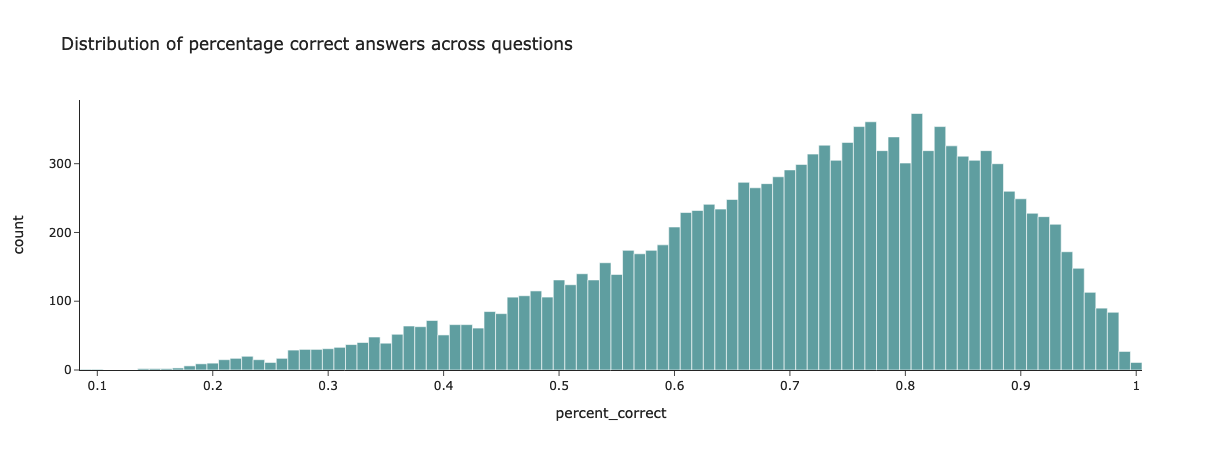

In [24]:
fig=px.histogram(train_questions_lim_pandas,x='percent_correct',title='Distribution of percentage correct answers across questions',template="simple_white")
fig.update_traces(marker=dict(color='cadetblue'))
fig.show()

# question_cnt=train_questions.groupby('content_id').agg({'content_id':'count'}).reset_index()
# question_cnt_pd=cudf.DataFrame.to_pandas(question_cnt)
# fig1=px.histogram(question_cnt_pd,x='content_id',title='Count of Question Occurences',template="simple_white")
# fig1.update_traces(marker=dict(color='cadetblue'))
# fig1.show()


In [ ]:
# summary


## Aggregates

### userid_df : per user stats...
This could be helpful, but one key thing to know is that new users pop into the test set!

In [24]:


userid_df = full_df[['user_id','answered_correctly']].groupby(['user_id']).agg(['sum','count'])
userid_df2 = full_df[['user_id','task_container_id']].groupby(['user_id']).agg(['nunique'])
# userid_df.columns = ['_'.join(col).strip() for col in userid_df.columns.values]
userid_df.columns = ['q_correct','q_total']
userid_df["pct_correct"] = userid_df["q_correct"]/userid_df["q_total"]
userid_df["log_q_correct"] = np.log10(userid_df["q_correct"])
userid_df["log_q_total"] = np.log10(userid_df["q_total"])
userid_df.merge(userid_df2,left_on='user_id',right_on='user_id')


#full_df['user_id']

/gpfs/home/s4s004/vanstee/anaconda3/envs/oce-pytorch-1.6/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/gpfs/home/s4s004/vanstee/anaconda3/envs/oce-pytorch-1.6/lib/python3.6/site-packages/pandas/core/reshape/merge.py:643: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


q_correct  q_total  pct_correct  log_q_correct  log_q_total  \
user_id                                                                   
115              32.0       46     0.695652       1.505150     1.662758   
124               7.0       30     0.233333       0.845098     1.477121   
2746             11.0       19     0.578947       1.041393     1.278754   
5382             84.0      125     0.672000       1.924279     2.096910   
8623             70.0      109     0.642202       1.845098     2.037426   
...               ...      ...          ...            ...          ...   
2147470770      173.0      226     0.765487       2.238046     2.354108   
2147470777      520.0      752     0.691489       2.716003     2.876218   
2147481750       38.0       50     0.760000       1.579784     1.698970   
2147482216      177.0      275     0.643636       2.247973     2.439333   
2147482888       15.0       27     0.555556       1.176091     1.431364   

            (task_container_id, nunique)  
user_id                                   
115                                   42  
124                                   16  
2746                                  19  
5382                                 125  
8623                                  97  
...                                  ...  
2147470770                           212  
2147470777                           476  
2147481750                            50  
2147482216                           275  
2147482888                            27  

[393656 rows x 6 columns]

array([[<AxesSubplot:title={'center':'q_correct'}>,
        <AxesSubplot:title={'center':'q_total'}>],
       [<AxesSubplot:title={'center':'pct_correct'}>,
        <AxesSubplot:title={'center':'log_q_correct'}>],
       [<AxesSubplot:title={'center':'log_q_total'}>, <AxesSubplot:>]],
      dtype=object)

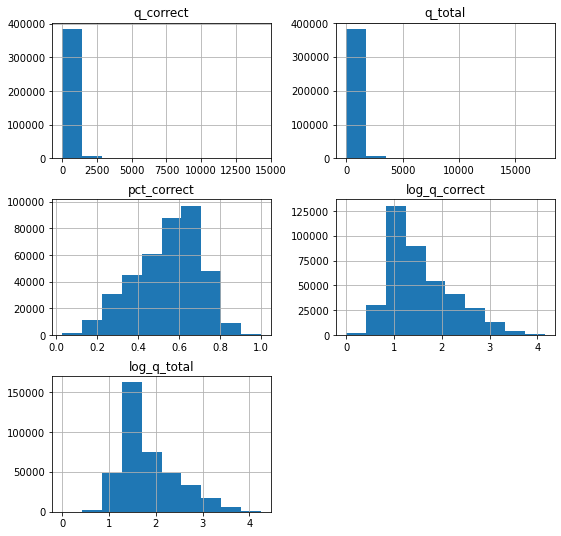

In [25]:
userid_df = userid_df.replace([np.inf, -np.inf], np.nan)
userid_df.dropna().hist(figsize=(9,9))

##  Data Understanding 
Can I explain in simple terms each column ?

In [26]:
# sample every Nth row
# eg sample every 5 rows, df.iloc[::5, :]
train_df.iloc[::1, :].head(30)

timestamp  user_id  content_id  content_type_id  task_container_id  \
0           0      115        5692                0                  1   
1       56943      115        5716                0                  2   
2      118363      115         128                0                  0   
3      131167      115        7860                0                  3   
4      137965      115        7922                0                  4   
5      157063      115         156                0                  5   
6      176092      115          51                0                  6   
7      194190      115          50                0                  7   
8      212463      115        7896                0                  8   
9      230983      115        7863                0                  9   
10     255381      115         152                0                 10   
11     280033      115         104                0                 11   
12     302994      115         108                0                 12   
13     328686      115        7900                0                 13   
14     352686      115        7901                0                 14   
15     376162      115        7971                0                 15   
16     398020      115          25                0                 16   
17     418008      115         183                0                 17   
18     437272      115        7926                0                 18   
19     468511      115        7927                0                 19   
20     490100      115           4                0                 20   
21     510583      115        7984                0                 21   
22     534187      115          45                0                 22   
23     557677      115         185                0                 23   
24     575289      115          55                0                 24   
25     597863      115        7876                0                 25   
26     621464      115           6                0                 26   
27     645415      115         172                0                 27   
28     670520      115        7898                0                 28   
29     692971      115         175                0                 29   

    answered_correctly  prior_question_elapsed_time  \
0                    1                          NaN   
1                    1                      37000.0   
2                    1                      55000.0   
3                    1                      19000.0   
4                    1                      11000.0   
5                    1                       5000.0   
6                    1                      17000.0   
7                    1                      17000.0   
8                    1                      16000.0   
9                    1                      16000.0   
10                   0                      17000.0   
11                   0                      22000.0   
12                   0                      23000.0   
13                   1                      21000.0   
14                   1                      24000.0   
15                   1                      22000.0   
16                   1                      21000.0   
17                   0                      20000.0   
18                   1                      18000.0   
19                   1                      17000.0   
20                   0                      29000.0   
21                   0                      20000.0   
22                   0                      19000.0   
23                   0                      21000.0   
24                   1                      22000.0   
25                   1                      16000.0   
26                   1                      20000.0   
27                   1                      22000.0   
28                   1                      22000.0   
29                   0                      23000.0   

   

### Row Filters

In [27]:
print("Rows with same user_id")
mask  =train_df['user_id']==115
train_df[mask]



Rows with same user_id


timestamp  user_id  content_id  content_type_id  task_container_id  \
0           0      115        5692                0                  1   
1       56943      115        5716                0                  2   
2      118363      115         128                0                  0   
3      131167      115        7860                0                  3   
4      137965      115        7922                0                  4   
5      157063      115         156                0                  5   
6      176092      115          51                0                  6   
7      194190      115          50                0                  7   
8      212463      115        7896                0                  8   
9      230983      115        7863                0                  9   
10     255381      115         152                0                 10   
11     280033      115         104                0                 11   
12     302994      115         108                0                 12   
13     328686      115        7900                0                 13   
14     352686      115        7901                0                 14   
15     376162      115        7971                0                 15   
16     398020      115          25                0                 16   
17     418008      115         183                0                 17   
18     437272      115        7926                0                 18   
19     468511      115        7927                0                 19   
20     490100      115           4                0                 20   
21     510583      115        7984                0                 21   
22     534187      115          45                0                 22   
23     557677      115         185                0                 23   
24     575289      115          55                0                 24   
25     597863      115        7876                0                 25   
26     621464      115           6                0                 26   
27     645415      115         172                0                 27   
28     670520      115        7898                0                 28   
29     692971      115         175                0                 29   
30     710402      115         100                0                 30   
31     732421      115        7859                0                 31   
32    1219624      115          57                0                 32   
33    1252621      115        7948                0                 33   
34    1284094      115         151                0                 34   
35    1320874      115         167                0                 35   
36    1359412      115        7897                0                 36   
37    1415188      115        7882                0                 37   
38    1468285      115        7962                0                 38   
39  667861680      115        1278                0                 39   
40  667971812      115        2065                0                 40   
41  667971812      115        2064                0                 40   
42  667971812      115        2063                0                 40   
43  668090043      115        3363                0                 41   
44  668090043      115        3365                0                 41   
45  668090043      115        3364                0                 41   

    answered_correctly  prior_question_elapsed_time  \
0                    1                          NaN   
1                    1                      37000.0   
2                    1                      55000.0   
3                    1                      19000.0   
4                    1                      11000.0   
5                    1                       5000.0   
6                    1                      17000.0   
7                    1                      17000.0   
8                    1        

In [28]:
print("Rows with same content_id")
mask  =train_df['content_id']==5692
train_df[mask]



Rows with same content_id


timestamp     user_id  content_id  content_type_id  \
0                    0         115        5692                0   
2385        4216576228       24418        5692                0   
8954                 0       51285        5692                0   
9280         330907575       91216        5692                0   
13269        560202977      138650        5692                0   
...                ...         ...         ...              ...   
101220110     94527847  2147192453        5692                0   
101222369   3751883721  2147269525        5692                0   
101225157   1209082871  2147413636        5692                0   
101229788  13078960454  2147470777        5692                0   
101230150    873328861  2147482216        5692                0   

           task_container_id  answered_correctly  prior_question_elapsed_time  \
0                          1                   1                          NaN   
2385                     497                   1                      21000.0   
8954                       0                   1                          NaN   
9280                     153                   1                      22000.0   
13269                    122                   1                      18000.0   
...                      ...                 ...                          ...   
101220110                 35                   1                      15000.0   
101222369                213                   1                      26000.0   
101225157                600                   1                      17000.0   
101229788                390                   1                      13000.0   
101230150                125                   1                      19000.0   

           prior_question_had_explanation  
0                                    <NA>  
2385                                 True  
8954                                 <NA>  
9280                                 True  
13269                                True  
...                                   ...  
101220110                           False  
101222369                            True  
101225157                            True  
101229788                            True  
101230150                            True  

[36514 rows x 8 columns]

In [29]:
print("Rows with same task_container_id")
mask  =train_df['task_container_id']==4
train_df[mask]


Rows with same task_container_id


timestamp     user_id  content_id  content_type_id  \
4             137965         115        7922                0   
50            189483         124        2064                0   
51            189483         124        2063                0   
52            189483         124        2065                0   
80             91945        2746         404                0   
...              ...         ...         ...              ...   
101229222   19189567  2147470777        2064                0   
101229223   19189567  2147470777        2063                0   
101229979      75162  2147481750         367                0   
101230029      77932  2147482216        4665                0   
101230309      86736  2147482888        4748                0   

           task_container_id  answered_correctly  prior_question_elapsed_time  \
4                          4                   1                      11000.0   
50                         4                   0                      18000.0   
51                         4                   0                      18000.0   
52                         4                   1                      18000.0   
80                         4                   0                      20000.0   
...                      ...                 ...                          ...   
101229222                  4                   0                      17000.0   
101229223                  4                   0                      17000.0   
101229979                  4                   1                      21000.0   
101230029                  4                   1                       9000.0   
101230309                  4                   1                      21000.0   

           prior_question_had_explanation  
4                                   False  
50                                  False  
51                                  False  
52                                  False  
80                                  False  
...                                   ...  
101229222                           False  
101229223                           False  
101229979                           False  
101230029                           False  
101230309                           False  

[692036 rows x 8 columns]

### Descriptive Statistics

In [31]:
categorical_overview,numerical_overview = quick_overview_1d_v2(train_df)
print("Categorical report")
display(categorical_overview)
print("Numerical report")
display(numerical_overview)

**quick_overview_1d_v2** : There are 99271300 observations in the dataset.
**quick_overview_1d_v2** : There are 8 variables in the dataset.
**quick_overview_1d_v2** : 


**quick_overview_1d_v2** : 
****************** Histogram of data types  *****************************

**quick_overview_1d_v2** : use df.dtypes ...
int8       2
int16      2
int32      1
int64      1
boolean    1
float32    1
Name: dtype, dtype: int64
**quick_overview_1d_v2** : 


**quick_overview_1d_v2** : 
****************** Generating Cardinality Report (all types) *****************************

**quick_overview_1d_v2** : 
****************** Generating NaNs Report *****************************

**quick_overview_1d_v2** : 
******************Generating Descriptive Statistics (numerical columns only) *****************************



answered_correctly content_type_id    timestamp      user_id  \
dtype                     int8            int8        int64        int32   
cardinality                  2               1     70897337       393656   
nan_count                    0               0            0            0   
pct_missing                  0               0            0            0   
count              9.92713e+07     9.92713e+07  9.92713e+07  9.92713e+07   
mean                  0.657236               0  7.70206e+09  1.07675e+09   
std                   0.474634               0   1.1595e+10  6.19699e+08   
min                          0               0            0          115   
25%                          0               0  5.19528e+08  5.40837e+08   
50%                          1               0  2.66961e+09  1.07181e+09   
75%                          1               0  9.92915e+09  1.61574e+09   
max                          1               0  8.74258e+10  2.14748e+09   

              content_id task_container_id prior_question_elapsed_time  \
dtype              int16             int16                     float32   
cardinality        13523             10000                        3258   
nan_count              0                 0                      392506   
pct_missing            0                 0                    0.395387   
count        9.92713e+07       9.92713e+07                 9.88788e+07   
mean              4994.4           907.811                     25423.9   
std              3288.95           1364.97                     19948.1   
min                    0                 0                           0   
25%                 2016               103                       16000   
50%                 4984               381                       21000   
75%                 7218              1099                       29666   
max                13522              9999                      300000   

            prior_question_had_explanation  
dtype                              boolean  
cardinality                              2  
nan_count                           392506  
pct_missing                       0.395387  
count                                  NaN  
mean                                   NaN  
std                                    NaN  
min                                    NaN  
25%                                    NaN  
50%                                    NaN  
75%                                    NaN  
max                                    NaN

Categorical report


prior_question_had_explanation
dtype                              boolean
cardinality                              2
nan_count                           392506
pct_missing                       0.395387

Numerical report


timestamp      user_id   content_id content_type_id  \
dtype              int64        int32        int16            int8   
cardinality     70897337       393656        13523               1   
nan_count              0            0            0               0   
pct_missing            0            0            0               0   
count        9.92713e+07  9.92713e+07  9.92713e+07     9.92713e+07   
mean         7.70206e+09  1.07675e+09       4994.4               0   
std           1.1595e+10  6.19699e+08      3288.95               0   
min                    0          115            0               0   
25%          5.19528e+08  5.40837e+08         2016               0   
50%          2.66961e+09  1.07181e+09         4984               0   
75%          9.92915e+09  1.61574e+09         7218               0   
max          8.74258e+10  2.14748e+09        13522               0   

            task_container_id answered_correctly  
dtype                   int16               int8  
cardinality             10000                  2  
nan_count                   0                  0  
pct_missing                 0                  0  
count             9.92713e+07        9.92713e+07  
mean                  907.811           0.657236  
std                   1364.97           0.474634  
min                         0                  0  
25%                       103                  0  
50%                       381                  1  
75%                      1099                  1  
max                      9999                  1

## Question data frame Aggregations

In [32]:
#reading in question df
questions_df = pd.read_csv('./questions.csv',                         
                            usecols=[0, 3],
                            dtype={'question_id': 'int16',
                              'part': 'int8'}
                          )
questions_df

question_id  part
0                0     1
1                1     1
2                2     1
3                3     1
4                4     1
...            ...   ...
13518        13518     5
13519        13519     5
13520        13520     5
13521        13521     5
13522        13522     5

[13523 rows x 2 columns]

In [33]:
#We remove data on lectures. They only represent about 2 percent of this training dataset and they will not be present in the test dataset:
train_df = train_df[train_df.content_type_id == False].sort_values('timestamp').reset_index(drop = True)

In [34]:
elapsed_mean = train_df.prior_question_elapsed_time.mean()

In [35]:
elapsed_mean

25423.742

## Question Averages

In [36]:
full_df = train_df[train_df['content_type_id'] == 0]
question_averages_df = full_df[['content_id','answered_correctly']].groupby(['content_id']).agg(['sum','count'])
question_averages_df.columns = ['correct','total']
question_averages_df["pct_correct"] = question_averages_df['correct'] / question_averages_df['total']

In [37]:
question_averages_df

correct  total  pct_correct
content_id                             
0            6266.0   6903     0.907721
1            6589.0   7398     0.890646
2           24890.0  44905     0.554281
3           17906.0  22973     0.779437
4           19461.0  31736     0.613215
...             ...    ...          ...
13518         683.0    868     0.786866
13519         528.0    924     0.571429
13520         579.0    861     0.672474
13521         703.0    870     0.808046
13522         786.0    860     0.913953

[13523 rows x 3 columns]

## 1D - Histograms

skipping column prior_question_had_explanation of type  boolean


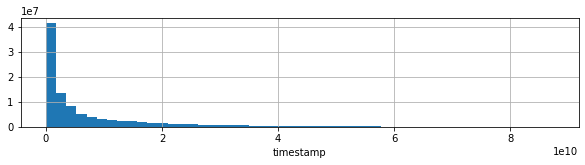

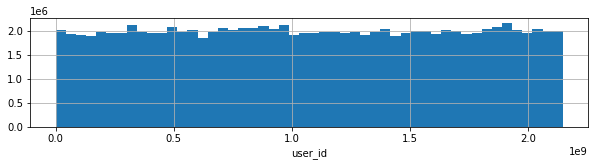

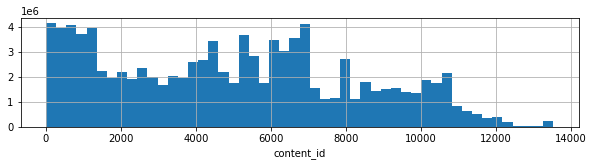

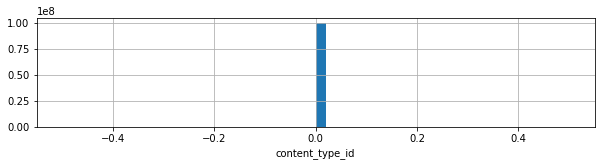

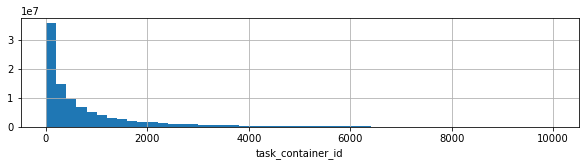

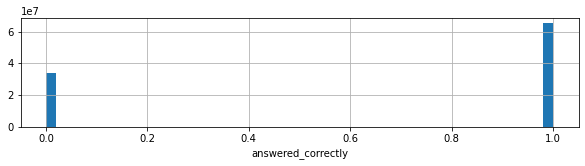

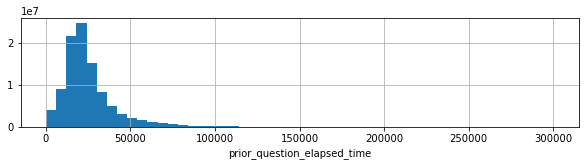

In [38]:


def plot_histograms(df) :
    for c in df.columns :
        if(re.match('float', str(df[c].dtype)) or re.match('int', str(df[c].dtype))) :
            plt.figure(c)
            df[c].hist(bins=50, figsize=(10,2)).set_xlabel(c)
        else :
            print("skipping column {} of type  {}".format(c,df[c].dtype))
plot_histograms(train_df)

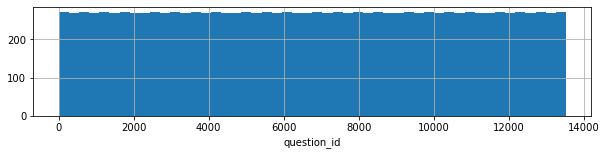

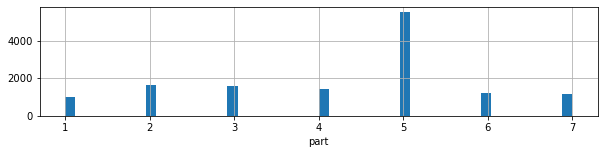

In [44]:
plot_histograms(questions_df)

In [45]:
!head lectures.csv

lecture_id,tag,part,type_of
89,159,5,concept
100,70,1,concept
185,45,6,concept
192,79,5,solving question
317,156,5,solving question
335,114,2,concept
484,179,5,concept
641,134,6,solving question
761,93,1,concept


## Are there Repeating sequences ??

In [42]:
full_df[full_df["content_id"] == 555]

timestamp     user_id  content_id  content_type_id  \
450862          18648   645732041         555                0   
480948          20754  1294748073         555                0   
495338          21490   139867391         555                0   
498033          21628   616568722         555                0   
500941          21776   447906311         555                0   
...               ...         ...         ...              ...   
99207624  73943384573  1994524782         555                0   
99208150  73964073577  1994524782         555                0   
99224084  75232820492  1418630818         555                0   
99226157  75453036214   197212993         555                0   
99263206  79987262230   530563603         555                0   

          task_container_id  answered_correctly  prior_question_elapsed_time  \
450862                    1                   0                      48000.0   
480948                    1                   1                      11000.0   
495338                    1                   0                      36000.0   
498033                    1                   0                      29000.0   
500941                    1                   0                      42000.0   
...                     ...                 ...                          ...   
99207624               1269                   1                      17000.0   
99208150               1305                   1                      11000.0   
99224084               3059                   1                      21000.0   
99226157               7401                   1                      31000.0   
99263206               3106                   1                      17000.0   

          prior_question_had_explanation  
450862                             False  
480948                             False  
495338                             False  
498033                             False  
500941                             False  
...                                  ...  
99207624                            True  
99208150                            True  
99224084                            True  
99226157                            True  
99263206                            True  

[12444 rows x 8 columns]

In [56]:
print("total number of questions for user .. {}".format(len(full_df[full_df["user_id"] == 1994524782])))
print("total number of unique questions for user .. {}".format(len(full_df[full_df["user_id"] == 1994524782]["content_id"].unique())))

total number of questions for user .. 1919
total number of unique questions for user .. 1501


In [63]:
 full_df[full_df["user_id"] == 1994524782]["content_id"].value_counts()

335     4
1266    4
855     4
363     4
2206    3
       ..
3230    1
3231    1
3232    1
3233    1
2       1
Name: content_id, Length: 1501, dtype: int64

In [69]:
user_qa = full_df[full_df["user_id"] == 1994524782]
user_qa_dups = user_qa[user_qa["content_id"] == 2206]
user_qa_dups

timestamp     user_id  content_id  content_type_id  \
35439162   1215885813  1994524782        2206                0   
35448233   1216328717  1994524782        2206                0   
99207512  73933642009  1994524782        2206                0   

          task_container_id  answered_correctly  prior_question_elapsed_time  \
35439162                447                   1                      13666.0   
35448233                452                   1                       4000.0   
99207512               1257                   1                      14000.0   

          prior_question_had_explanation  
35439162                            True  
35448233                            True  
99207512                            True

In [70]:
full_df.to_pickle("full_df.pkl")

In [1]:
full_df

NameError: name 'full_df' is not defined